# Finetuning

This tutorial illustrates how to fine-tune the `GR00T-N1` pretrained checkpoint on a post-training 
dataset using the same embodiment. This showcases the benefit of post-training, transforming a generalist model into a specialist and demonstrating a performance gain.

For this tutorial, we will use the demo dataset `robot_sim.PickNPlace` from the [demo_data](./demo_data) folder. 

We will first load the pre-trained model and evaluate it on the dataset. Then we will finetune the model on the dataset and evaluate the performance.

## Pre-trained Model

In [1]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.simplefilter("ignore", category=FutureWarning)

/home/nlp/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.5.1+cu124)
    Python  3.10.13 (you have 3.10.16)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/home/nlp/.local/lib/python3.10/site-packages/xformers/triton/softmax.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16 

In [2]:
PRE_TRAINED_MODEL_PATH = "nvidia/GR00T-N1-2B"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "../demo_data/robot_sim.PickNPlace"


data_config = DATA_CONFIG_MAP["gr1_arms_only"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()


dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
    training=False
)

Initialized dataset robot_sim.PickNPlace with EmbodimentTag.GR1


In [ ]:

pre_trained_policy = Gr00tPolicy(
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)


mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=4,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

## Finetuning the Model

Now we will finetune the model on the dataset. Without going into the details of the finetuning process, we will use the `gr00t_finetune.py` script to finetune the model. You can run the following command to finetune the model. 

```bash
python scripts/gr00t_finetune.py --dataset-path ./demo_data/robot_sim.PickNPlace --num-gpus 1 --max-steps 2000 --output-dir checkpoints/gr00t-1/finetuned-model --data-config gr1_arms_only
```

_To get a full list of the available arguments, you can run `python scripts/gr00t_finetune.py --help`._

The script will save the finetuned model in the `/tmp/gr00t-1/finetuned-model` directory. We will load the finetuned model with `500` checkpoint steps.  

### Evaluation of the Fine-tuned Model

Now we can evaluate the fine-tuned model by running the policy on the dataset and see how well it performs. We will use a utility function to evaluate the policy on the dataset. This is similar to the previous tutorial in [1_pretrained_model.ipynb](1_pretrained_model.ipynb)

Model not found or avail in the huggingface hub. Loading from local path: ../checkpoints/gr00t-1/finetuned-model/checkpoint-500
Loading pretrained dual brain from ../checkpoints/gr00t-1/finetuned-model/checkpoint-500
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: ../checkpoints/gr00t-1/finetuned-model/checkpoint-500
Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.5530612866938642
Average inference time per action: 

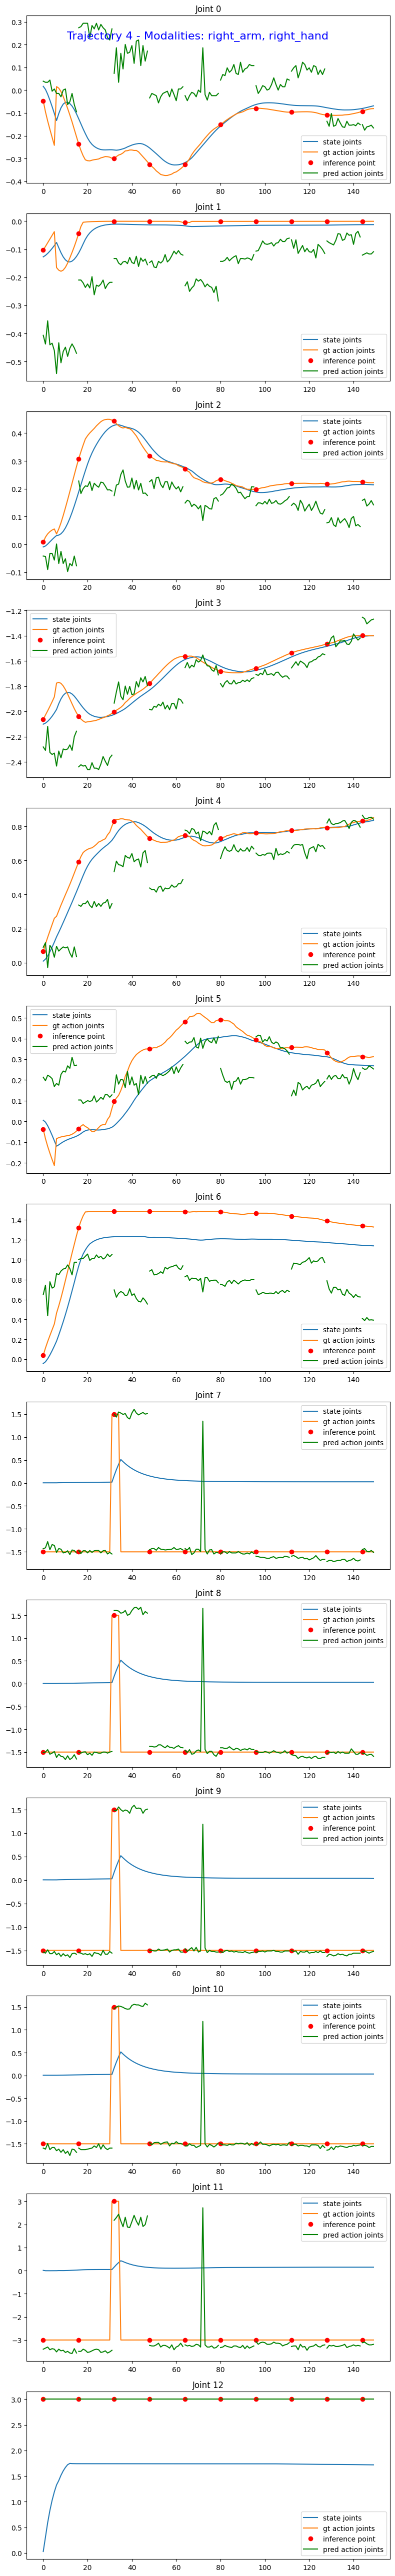

MSE loss for trajectory 0: 0.5530612866938642


In [3]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../checkpoints/gr00t-1/finetuned-model/checkpoint-500"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=4,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Yaay! We have finetuned the model and evaluated it on the dataset. We can see that the model has learned the task and is able to perform the task better than the pre-trained model.

In [4]:
del pre_trained_policy
del finetuned_policy

Model not found or avail in the huggingface hub. Loading from local path: ../checkpoints/gr00t-1/finetuned-model/checkpoint-2000
Loading pretrained dual brain from ../checkpoints/gr00t-1/finetuned-model/checkpoint-2000
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: ../checkpoints/gr00t-1/finetuned-model/checkpoint-2000
Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.5327065787191495
Average inference time per actio

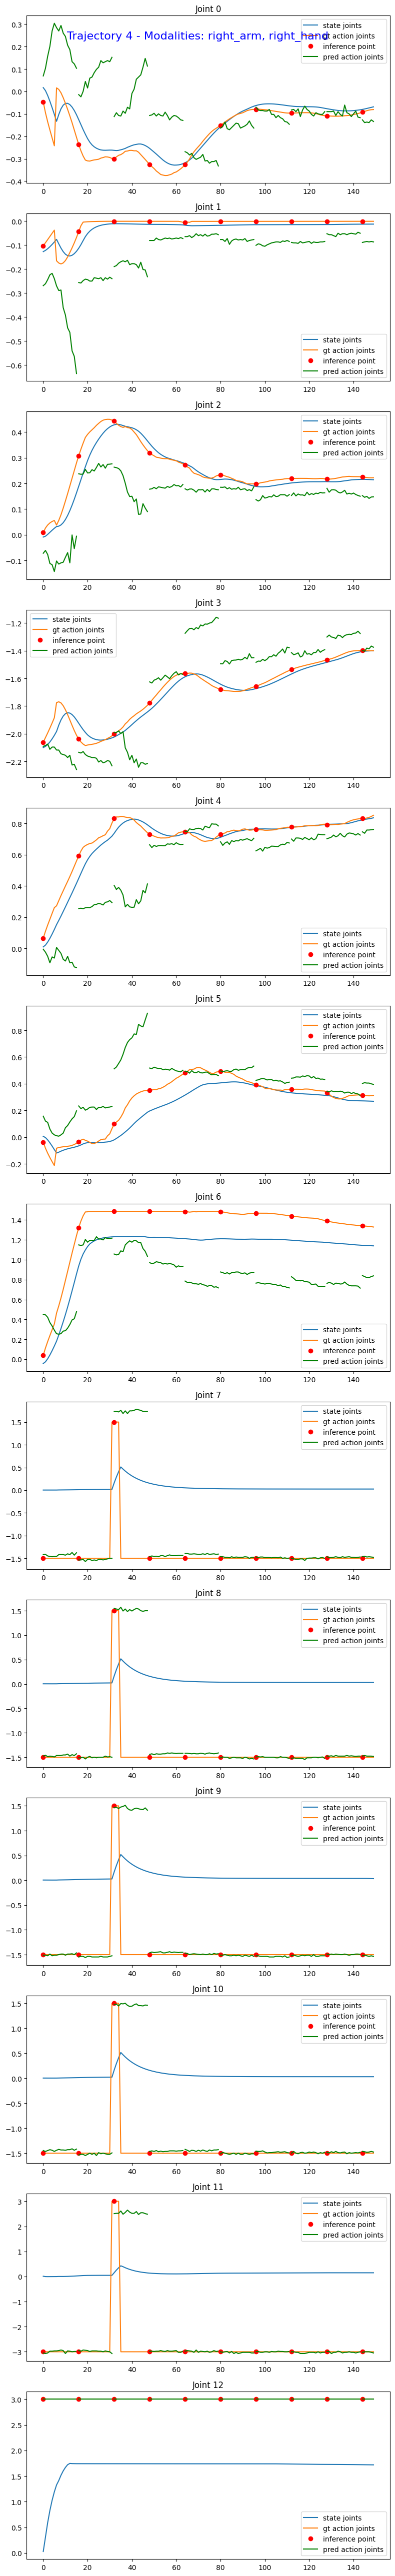

MSE loss for trajectory 0: 0.5327065787191495


In [5]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../checkpoints/gr00t-1/finetuned-model/checkpoint-2000"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=4,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Model not found or avail in the huggingface hub. Loading from local path: ../checkpoints/gr00t-1/finetuned-model/checkpoint-2000
Loading pretrained dual brain from ../checkpoints/gr00t-1/finetuned-model/checkpoint-2000
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: ../checkpoints/gr00t-1/finetuned-model/checkpoint-2000
Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


inferencing at step:  4
inferencing at step:  8
inferencing at step:  12
inferencing at step:  16
inferencing at step:  20
inferencing at step:  24
inferencing at step:  28
inferencing at step:  32
inferencing at step:  36
inferencing at step:  40
inferencing at step:  44
inferencing at step:  48
inferencing at step:  52
inferencing at step:  56
inferencing at step:  60
inferencing at step:  64
inferencing at step:  68
inferencing at step:  72
inferencing at step:  76
inferencing at step:  80
inferencing at step:  84
inferencing at step:  88
inferencing at step:  92
inferencing at step:  96
inferencing at step:  100
inferencing at step:  104
inferencing at step:  108
inferencing at step:  112
inferencing at step:  116
inferencing at step:  120
inferencing at step:  124
inferencing at step:  128
inferencing at step:  132
inferencing at step:  136
inferencing at step:  140
inferencing at step:  144
inferencing at step:  148
Unnormalized Action MSE across single traj: 0.5532735732282767
A

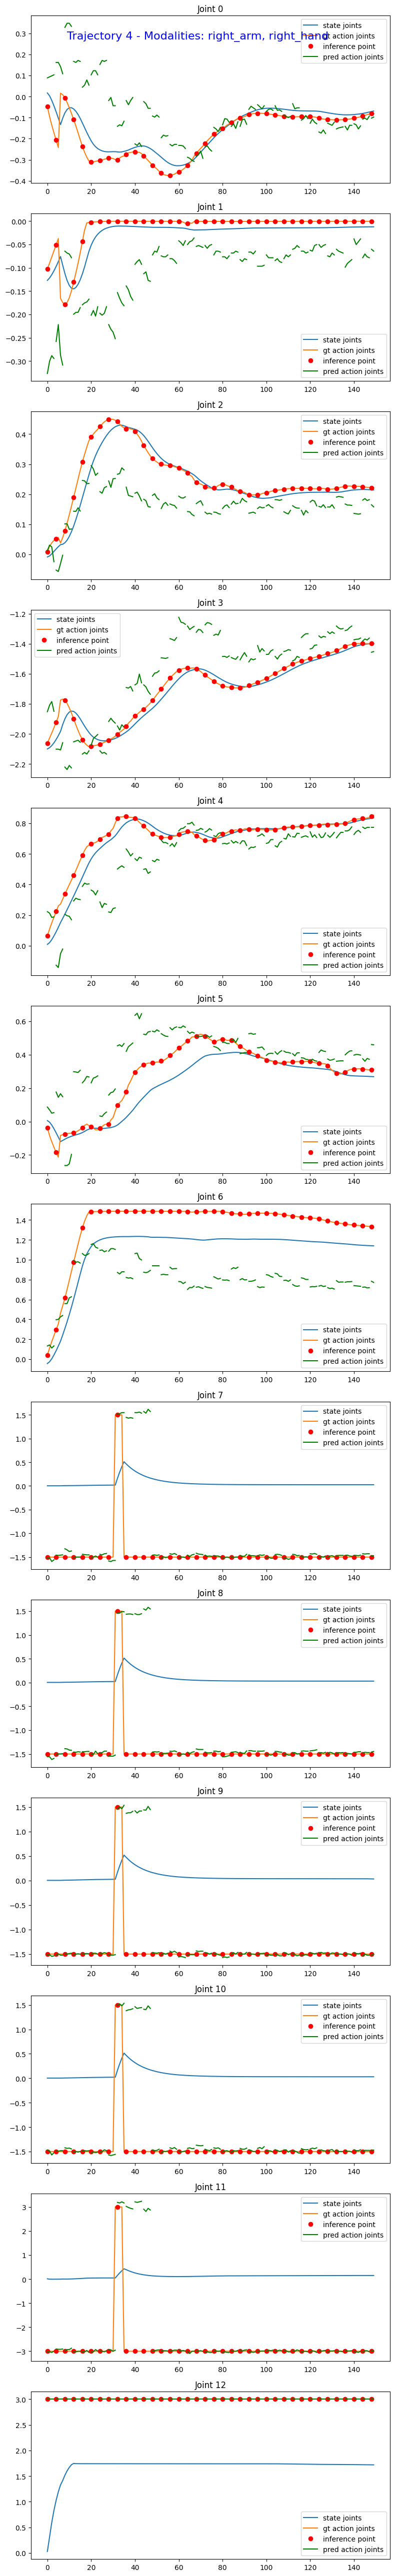

In [3]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../checkpoints/gr00t-1/finetuned-model/checkpoint-2000"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=4,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=4,
    plot=True
)